<a href="https://colab.research.google.com/github/AlbezJelt/compass-aligned-graph-embeddings/blob/main/notebooks/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%%capture
!pip install folium==0.2.1
!pip install git+https://github.com/valedica/gensim.git
!pip install -U cade

!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/models/wiki_walks_from_dbpedia.model
!wget https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/models/wikidata_walks_final.model

In [13]:
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cosine

import collections
import warnings
import json
import requests
import re

warnings.filterwarnings('ignore')

In [5]:
#load dictionary with labels
with requests.get("https://raw.githubusercontent.com/AlbezJelt/compass-aligned-graph-embeddings/main/data/wikidata_label_dictionary.json", "rt") as req:
  label_dict = json.loads(req.text)

In [9]:
model1 = Word2Vec.load("wiki_walks_from_dbpedia.model")
model2 = Word2Vec.load("wikidata_walks_final.model")


In [10]:
# parte da entità di wikidata e estrae i 3 most similar.
# differenzia se gli estratti sono entità con o senza sameAs e aggiunge nodi e archi
def graph_wiki_leaf(start):
  leafs = model1.wv.similar_by_vector(model2[start])[slice(0,3)]
  for j in leafs:
    word = label_dict[j[0]]
    weight = j[1]
    edge = (label_dict[start], word)
    if word not in G:
      if j[0] in model2.wv.vocab:
        G.add_node(word, lab = "both")
      elif re.match("^Q\d+$", j[0]):
        G.add_node(word, lab="dbpedia")
      elif not re.match("^Q\d+$", j[0]):
        G.add_node(word, lab="db_mot_same_as")
    if not(G.has_edge(*edge[:2])):
      G.add_edge(label_dict[start], word, weight=round(weight,2))

# partendo da entità di dbpedia estrai i 3 most silmilar di wikidata
# crea così nodi, se già non esistono, e archi 
def graph_dbpedia_leaf(start):
  leafs = model2.wv.similar_by_vector(model1[start])[slice(0,3)]
  for k in leafs:
    word = label_dict[k[0]]
    weight = k[1]
    edge = (label_dict[start], word)
    if word not in G:
      if k[0] in model1.wv.vocab:
        G.add_node(word, lab = "both")
      else:
        G.add_node(word, lab = "wiki")
    if not(G.has_edge(*edge[:2])):
      G.add_edge(label_dict[start], word, weight=round(weight,2))

In [11]:
def graph_creation(startpoint, epoch):
  if epoch == 0:
    return 0
  similar_db_wi = model2.wv.similar_by_vector(model1[startpoint])[slice(0,3)]
  similar_wi_db = model1.wv.similar_by_vector(model2[startpoint])[slice(0,3)]
  similar = similar_db_wi + similar_wi_db
  if startpoint not in G:
      G.add_node(label_dict[startpoint], lab = "both")
  for i in similar:
    word = label_dict[i[0]]
    weight = i[1]
    edge = (label_dict[startpoint], word)
    match = re.match("^Q\d+$", i[0])
    #se appartiene a entrambi i vocabolari, aggiunge nodi e archi e ricorsione
    if i[0] in model1.wv.vocab and i[0] in model2.wv.vocab:
      if word not in G:
        G.add_node(word, lab = "both")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_creation(i[0], epoch-1)
    # se appartiene solo al modello di dbpedia controlla se il nodo ha il sameAS
    # o no e lo aggiunge, aggiunge l'arco e chiama dbpedia_leaf
    elif i[0] in model1.wv.vocab and i[0] not in model2.wv.vocab:
      if word not in G and match:
        G.add_node(word, lab = "dbpedia")
      elif word not in G and not match:
        G.add_node(word, lab="db_not_same_as")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_dbpedia_leaf(i[0])
    # se appartiene solo al modello di wikidata aggiunge nodo, aggiunge 
    #l'arco e chiama wikidata_leaf
    elif i[0] not in model1.wv.vocab and i[0] in model2.wv.vocab:
      if word not in G:
        G.add_node(word, lab = "wiki")
      if not(G.has_edge(*edge[:2])):
        G.add_edge(label_dict[startpoint], word, weight=round(weight,2))
      graph_wiki_leaf(i[0])

  return 0

In [14]:
import networkx as nx
G=nx.DiGraph(directed = True)
startpoint = "Q300920"
graph_creation(startpoint, 4)

0

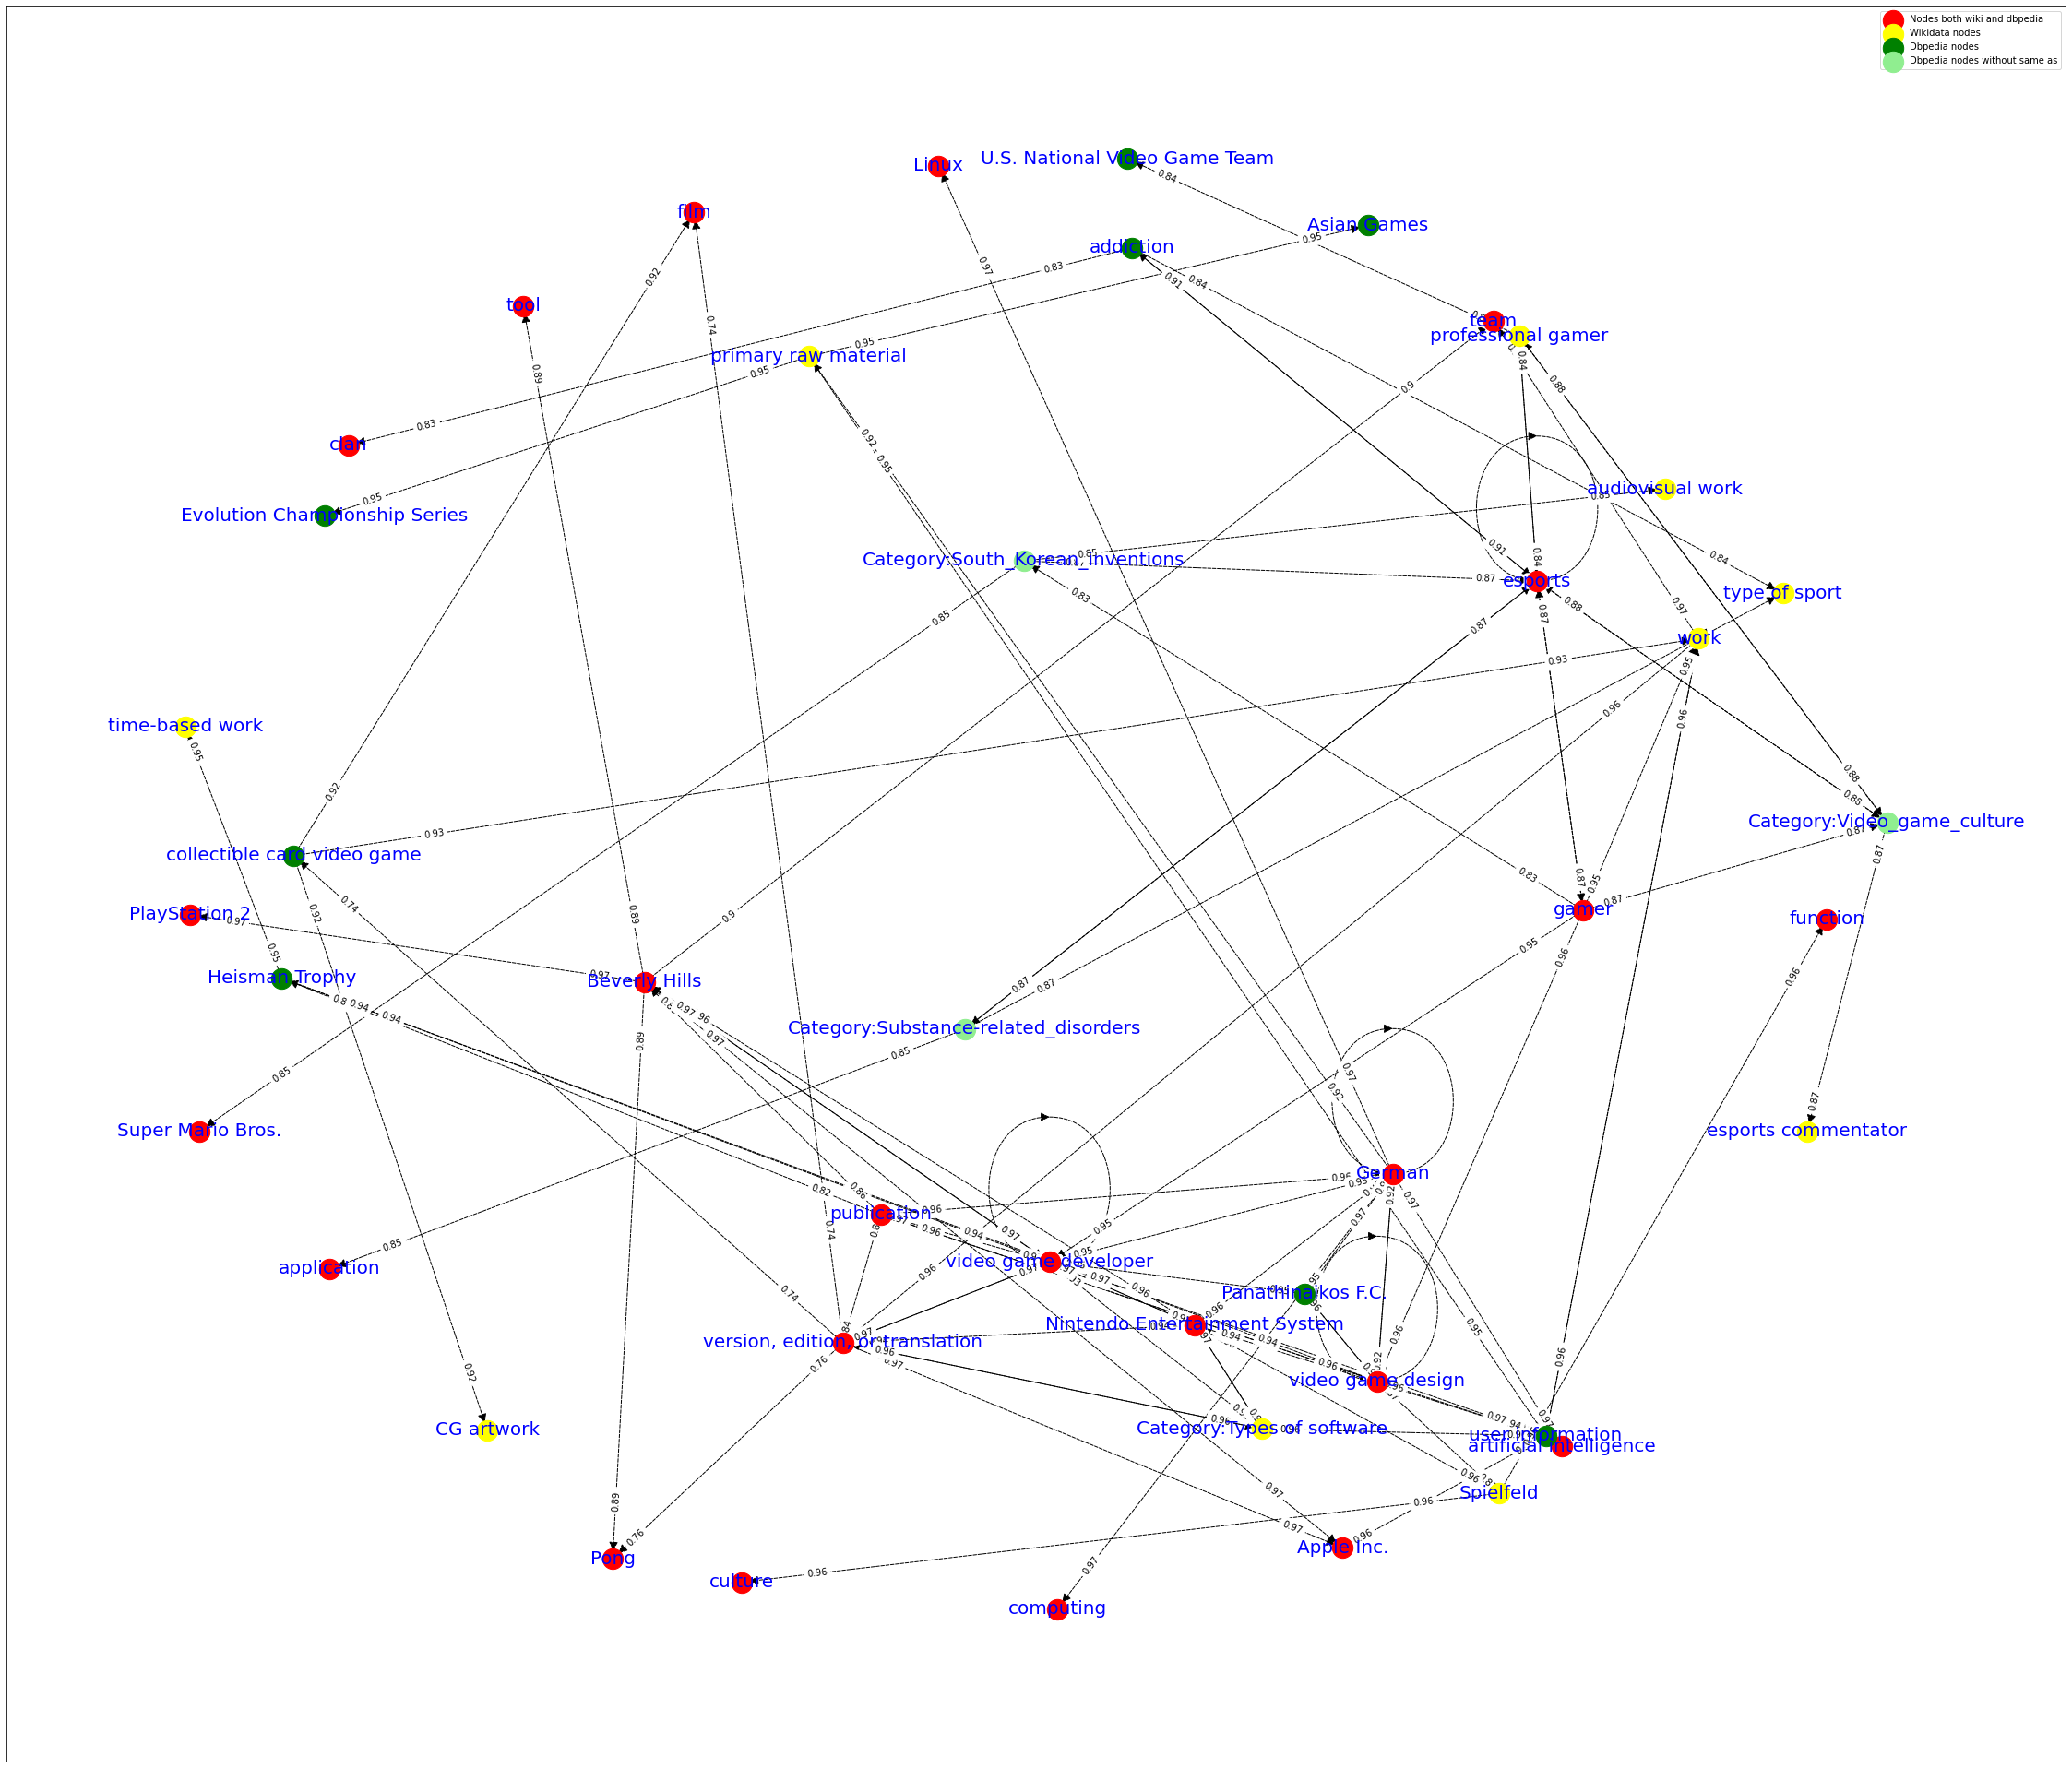

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,35))
pos = nx.spring_layout(G, center = (0,0))
for i in pos:
  #pos[i][0] = (pos[i][0]) * 10 # x coordinate
  #pos[i][1] = (pos[i][1]) * 10 # y coordinate
  distance = (pos[i][0]**2+pos[i][1]**2)**(1/2)
  pos[i][0] = (pos[i][0]) * (5**(1-distance))
  pos[i][1] = (pos[i][1]) * (4**(1-distance))

both_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'both']  
wiki_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'wiki']  
dbpedia_nodes = [n for n,v in G.nodes(data=True) if v['lab'] == 'dbpedia']
dbpedia_not_same_as = [n for n,v in G.nodes(data=True) if v['lab'] == 'db_not_same_as']   

nx.draw_networkx_nodes(G, pos, both_nodes, node_size=500, node_color='red', label='Nodes both wiki and dbpedia')
nx.draw_networkx_nodes(G, pos, wiki_nodes, node_size=500, node_color='yellow', label='Wikidata nodes')
nx.draw_networkx_nodes(G, pos, dbpedia_nodes, node_size=500, node_color='green', label='Dbpedia nodes')
nx.draw_networkx_nodes(G, pos, dbpedia_not_same_as, node_size=500, node_color='lightgreen', label='Dbpedia nodes without same as')
nx.draw_networkx_edges(G, pos, arrows = True, arrowsize=20, style='dashed')
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.1)
nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G,'weight'), label_pos=0.9)
nx.draw_networkx_labels(G, pos, font_color="blue", font_size=20)
plt.legend(scatterpoints = 1)
plt.show()

In [16]:
%%capture
!pip install pyvis

In [17]:
from pyvis.network import Network
from IPython.core.display import display, HTML
net = Network(notebook=True)
net.from_nx(G)
net.show_buttons(filter_="physics")
net.show("net.html")
display(HTML('net.html'))



In [35]:
def not_same_graph(dbpedia):
  similar = model2.wv.similar_by_vector(model1[dbpedia])[slice(0,3)]
  for i in similar:
    word = label_dict[i[0]]
    weight = round(i[1],2)
    edge = (dbpedia, word, weight)
    if word not in N:
      N.add_node(word, lab="wikidata")
    if not(N.has_edge(*edge[:2])):
        N.add_edge(dbpedia, word, weight=weight)


In [36]:
N=nx.Graph()
l=[]
for vocab in model1.wv.vocab:
  if not re.match("^Q\d+$", vocab):
    l.append(vocab)

for vocab in l:
  if vocab not in N:
    N.add_node(vocab, lab="dbpedia")
  not_same_graph(vocab)

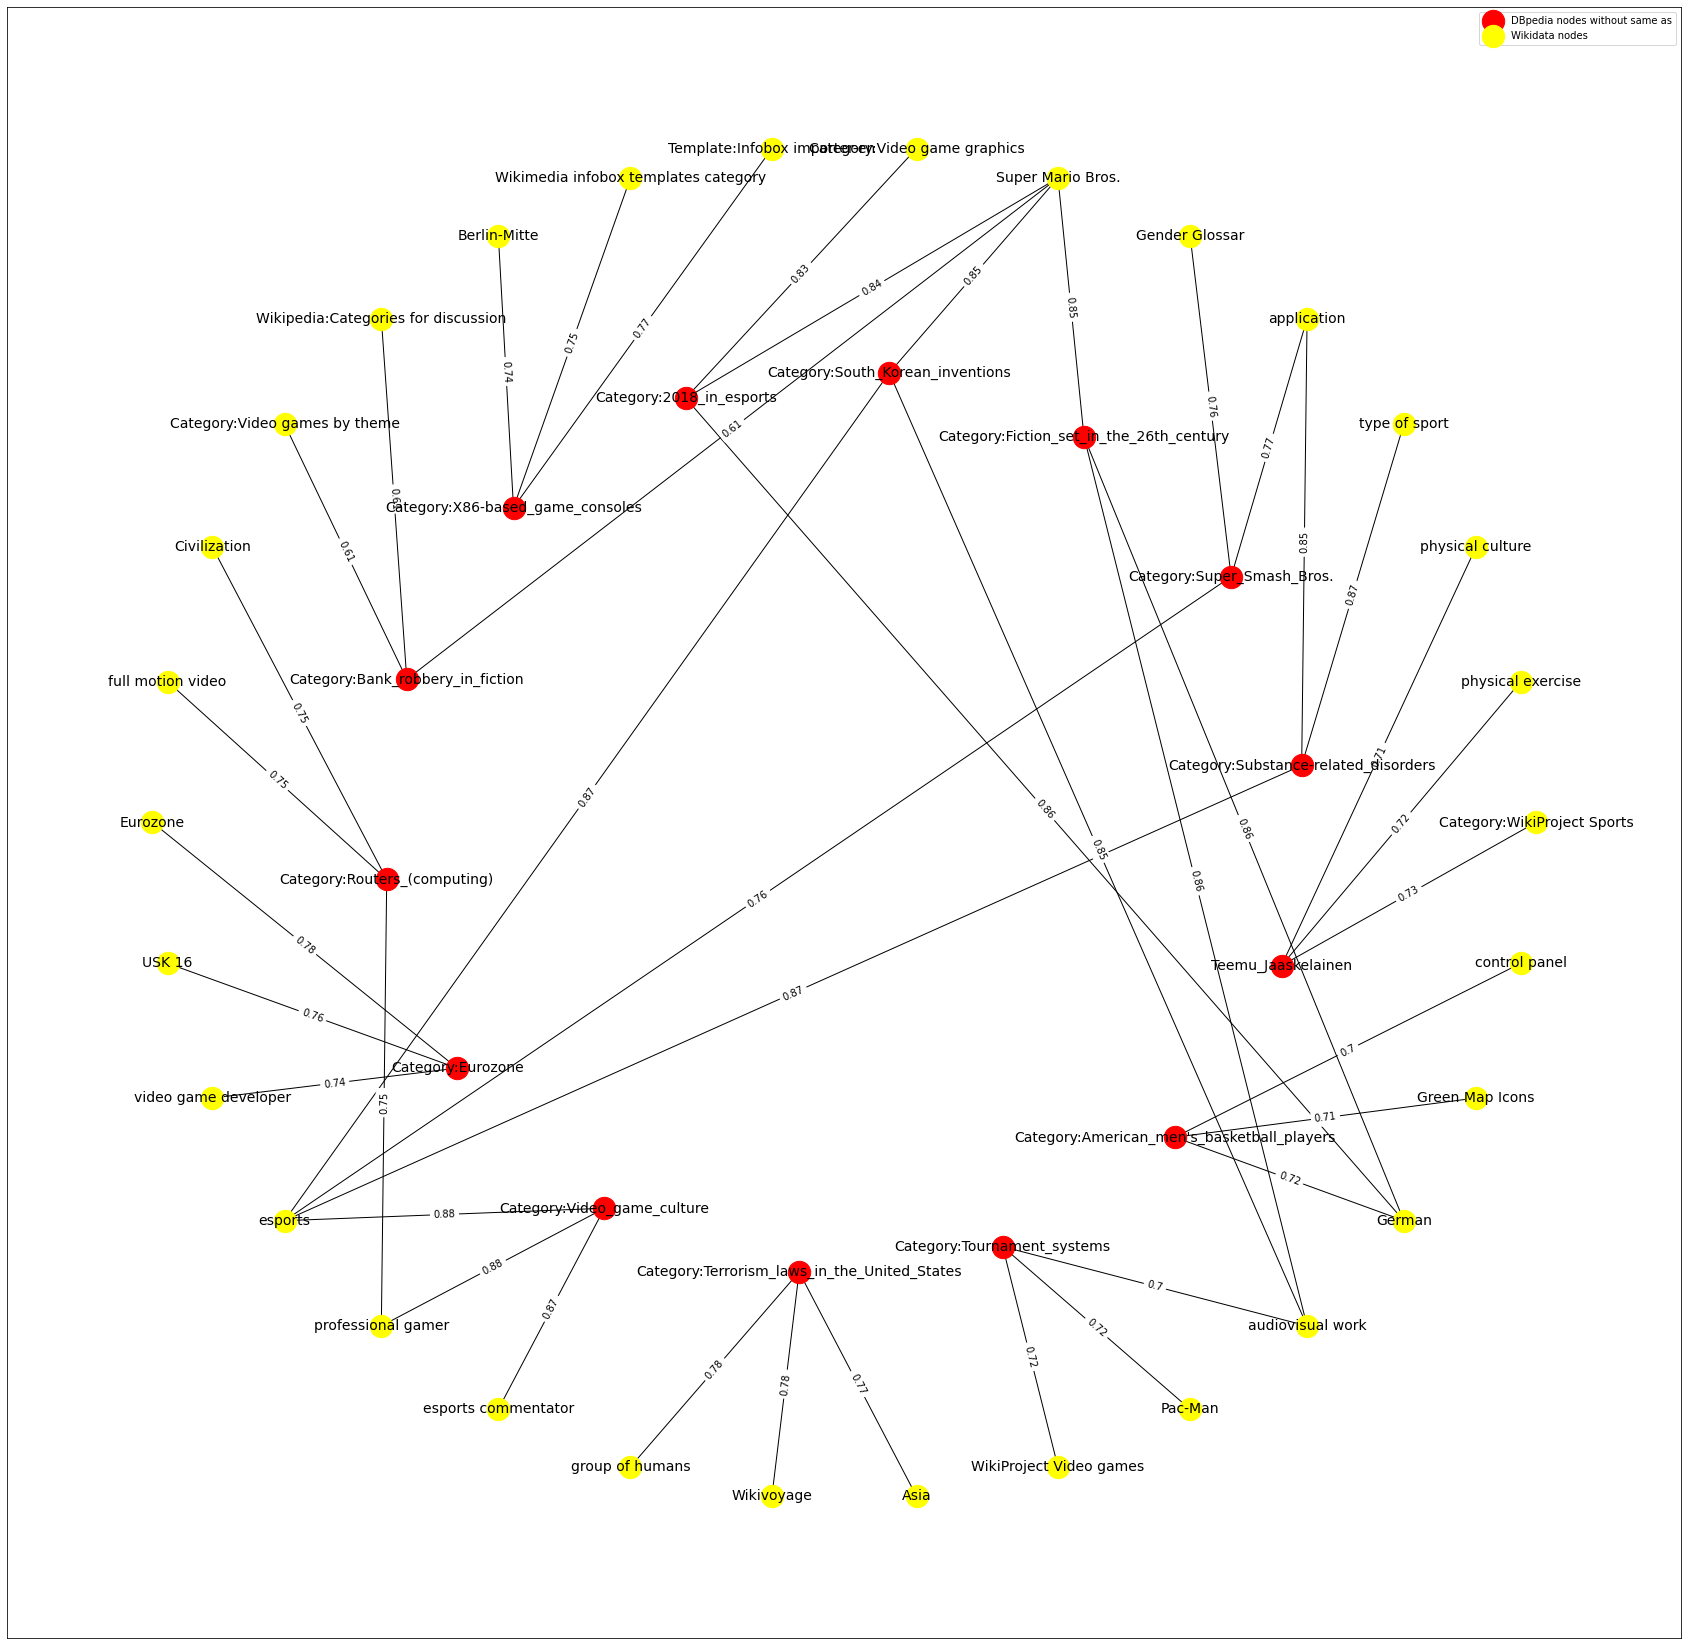

In [46]:
import math
plt.figure(figsize=(30,30))
N_dbpedia_nodes = [n for n,v in N.nodes(data=True) if v['lab'] == 'dbpedia']
N_wikidata_nodes = [n for n,v in N.nodes(data=True) if v['lab'] == 'wikidata']
pos1 = nx.shell_layout(N_dbpedia_nodes, center=(0,0), rotate=10)
pos2 = nx.shell_layout(N_wikidata_nodes, center=(0,0))
for i in pos1:
  pos1[i][0] = (pos1[i][0])*20
  pos1[i][1] = (pos1[i][1])*20
for j in pos2:
  pos2[j][0] = pos2[j][0]*30
  pos2[j][1] = pos2[j][1]*30
pos3 = {**pos1, **pos2}

nx.draw_networkx_nodes(N, pos3, N_dbpedia_nodes, node_size=500, node_color='red', label='DBpedia nodes without same as')
nx.draw_networkx_nodes(N, pos3, N_wikidata_nodes, node_size=500, node_color='yellow', label='Wikidata nodes')
nx.draw_networkx_edges(N, pos3)
nx.draw_networkx_edge_labels(N, pos3, nx.get_edge_attributes(N,'weight'), label_pos=0.5)
nx.draw_networkx_labels(N, pos3, font_size=14)
plt.legend(scatterpoints = 1)
plt.show()

In [71]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 8.5 MB/s 


In [73]:
import operator
import xlsxwriter
similarity_list=[]
for vocab in model2.wv.vocab:
  similar = model1.wv.similar_by_vector(model2.wv[vocab])[slice(0,5)]
  for sim in similar:
    if sim[0] in l:
      similarity_list.append([label_dict[vocab],sim[0], sim[1]])

similarity_list = (sorted(similarity_list, key=operator.itemgetter(1), reverse=True))
similarity_list.insert(0,["Wikidata", "DBpedia", "Similarity"])

with xlsxwriter.Workbook('similarity.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(similarity_list):
        worksheet.write_row(row_num, 0, data)